# `rioxarray`

In this lesson we will introduce [`rioxarray`](https://corteva.github.io/rioxarray/stable/), a Python extension for `xarray` to manipulate `xarray.DataArray`s as rasters. 

The name `rioxarray` stands for *raster input/output + xarray*. 

`rio`: Raster Input Output

## About the data
The raster files we will use today come from the [US National Agriculture Imagery Program (NAIP)](https://naip-usdaonline.hub.arcgis.com). 
NAIP images are are high-resolution aerial images with four spectral bands: red (R), green (G), blue (B) and near-infrared (NIR). 
The raster's we'll use today are from 2020.

The data used in this lesson was pre-processed from a complete NAIP scene to separate the RGB bands from the NIR band and reduce the spatial extent. 
The data was accessed through [Microsoft's Planetary Computer NAIP data repository](https://planetarycomputer.microsoft.com/dataset/naip#overview).

## Import a TIF file

Let's start by loading the libraries we will use: 

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr

There are [multiple ways of opening a TIF file using `xarray` or `rioxarray`](https://corteva.github.io/rioxarray/html/getting_started/getting_started.html). 
Using the `rioxarray.open_rasterio()` function to open the TIF file is a simple way to import the raster file as an `xarray.DataArray` and make sure all our geospatial data gets loaded correctly:

In [ ]:
# Import NIR TIF file
# Make sure this is the PATH TO THE DATA FOLDER CONTAINING THE RASTERS
root = os.path.join('data', 'rioxarray_lesson_data')



In [5]:
nir = rioxr.open_rasterio(os.path.join(root, 'NAIP_SB_nir.tif'))
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)> Size: 8MB
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [10]:
print(type(nir.values))

nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

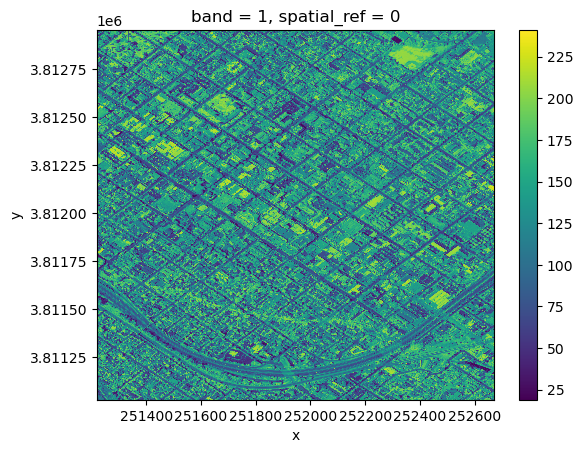

In [9]:
nir.plot()

## Drop a dimension 

Our raster has an unnecessary extra dimension: band. 

In [12]:
print("Size of dimensions: ", dict(nir.sizes))

Size of dimensions:  {'band': 1, 'y': 3208, 'x': 2419}


We can "squeeze the dimension" of length 1 by:

1. Using the `squeeze()` method. No parameters = gets rid of all dimensions of length one.

2. Removing associated coordinates for this fimension using `drop()`

In [13]:
print(nir.dims, nir.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


In [14]:
# Remove length 1 dimensions (band)
nir = nir.squeeze()
print(nir.dims, '\n', nir.coords)

('y', 'x') 
 Coordinates:
    band         int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


In [15]:
# Remove coordinates associate with band
nir = nir.drop_vars('band')
print(nir.dims, '\n', nir.coords)

('y', 'x') 
 Coordinates:
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


## `rio` accessor

Use the `.rio` accessor for an `xarray.DataArray` to access its raster properties.

Example:

In [16]:
# Examine raster attribute using the rio accessor
print('Number of bands: ', nir.rio.count)
print('Height:', nir.rio.height)
print('Width: ', nir.rio.width, '\n')

print('Spatial bounding box: ', nir.rio.bounds())

print('CRS: ', nir.rio.crs)

Number of bands:  1
Height: 3208
Width:  2419 

Spatial bounding box:  (251218.8, 3811027.2, 252670.19999999998, 3812952.0)
CRS:  EPSG:26911


## Multi band raster

In [19]:
# Import RGB raster
rgb = rioxr.open_rasterio(os.path.join(root, 'NAIP_SB_rgb.tif'))
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)> Size: 23MB
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [20]:
print('CRS: ', rgb.rio.crs)

CRS:  EPSG:26911


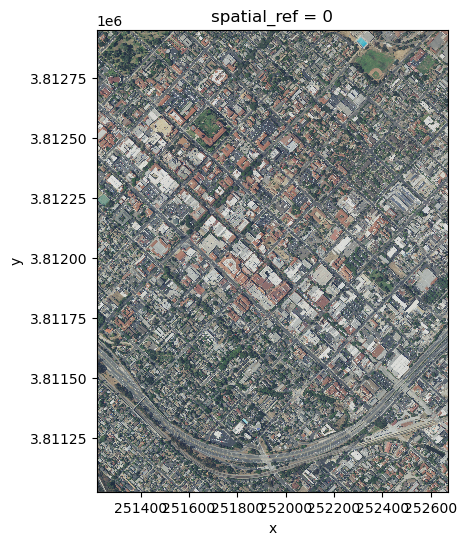

In [22]:
# Plot three bands as an rgb image
rgb_aspect_ratio = rgb.rio.width/ rgb.rio.height # Raster's aspect raio
rgb.plot.imshow(size = 6, # Plot's height in inches
                aspect = rgb_aspect_ratio
                )

## Clip raster

Our area of interest (AOI) is a smaller region around NCEAS. 

In [23]:
# Import AOI around NCEAS building
aoi = gpd.read_file(os.path.join(root, 'SB_aoi.geojson'))

<Axes: >

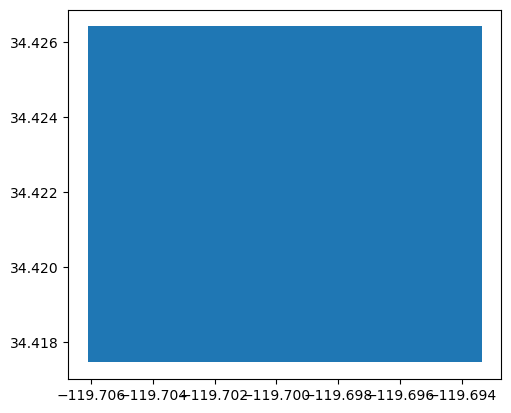

In [24]:
aoi.plot()

In [26]:
# Examine CRSs
print('aoi CRS: ', aoi.crs)
print('nir CRS: ', nir.rio.crs)
print('rgb CRS: ', rgb.rio.crs)

aoi CRS:  EPSG:4326
nir CRS:  EPSG:26911
rgb CRS:  EPSG:26911


In [27]:
# Reproject AOI and rgb CRS
aoi = aoi.to_crs(rgb.rio.crs)

assert aoi.crs == rgb.rio.crs

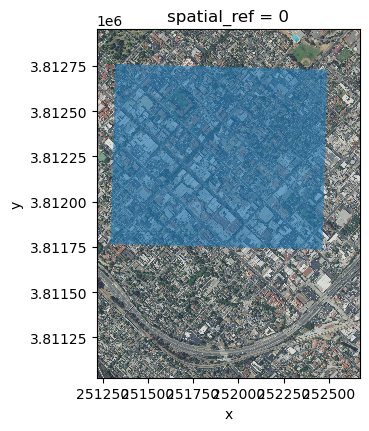

In [29]:
fig, ax = plt.subplots(figsize = (6, 6*rgb_aspect_ratio))

rgb.plot.imshow(ax = ax)
aoi.plot(ax= ax, alpha=0.6)
plt.show()

To clip raster using AOI polygon with the `rio.clip_box()` method

In [30]:
# Clip rasters to AOI
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
nir_small = nir.rio.clip_box(*aoi.total_bounds)

Original shape:  (3208, 2419)
Clipped shape:  (1710, 1995)


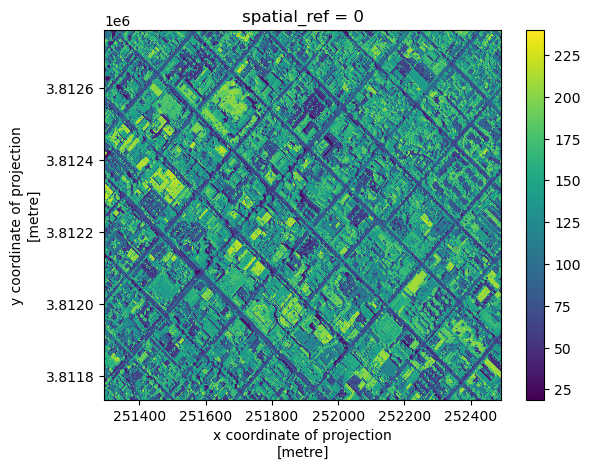

In [32]:
# Examine clipped data
print('Original shape: ', nir.shape)
print('Clipped shape: ', nir_small.shape)
nir_small.plot()

Original shape:  (3, 3208, 2419)
Clipped shape:  (3, 1710, 1995)


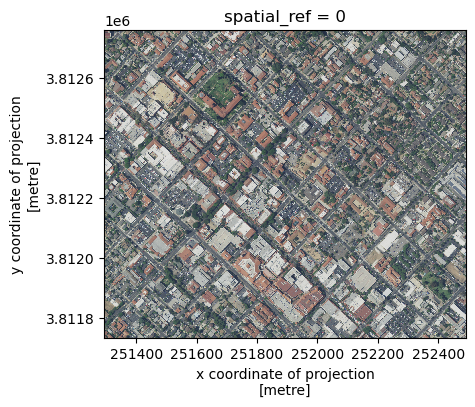

In [34]:
# Examine clipped data
print('Original shape: ', rgb.shape)
print('Clipped shape: ', rgb_small.shape)

# Plot with correct sizes
ratio = rgb_small.rio.width / rgb_small.rio.height # Plot in certain dimensions
rgb_small.plot.imshow(size=4, aspect = ratio)

## Raster math

We will compute the Normalized Difference Vegetation Index (NDVI) over our AOI.

NDVI is an index commonly used to check if areas have live green vegetation or not.
Values from -1 to 1.
- NDVI <0 : water surfaces, manmade structures, rocks, clouds, snow
- 0.1 < NDIV < 0.2: bare soil
- 0.2 < NDVI < 0.5: sparse vegetation
- 0.5 < NDVI: dense vegetation canopy

NDVI calculation:
$$ NDVI = \frac{NIR - Red}{NIR + Red}$$

In [ ]:
# Source only the red banc
red = rgb_small.sel(band=1)
red

<xarray.DataArray (y: 1710, x: 1995)> Size: 3MB
[3411450 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 16kB 2.513e+05 2.513e+05 ... 2.525e+05 2.525e+05
  * y            (y) float64 14kB 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [36]:
ndvi = (nir - red)/ (nir+red)

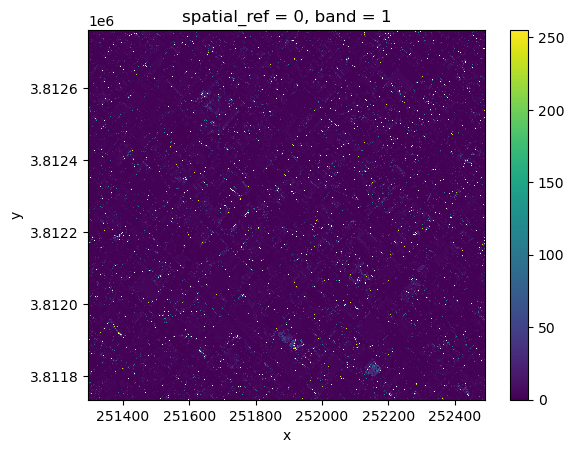

In [37]:
ndvi.plot()

## Data type issues

The `uint8` (8-bit unsigned integer) is a very small data type that only holds from 0 to 255. In particular, calculations don't return what we are used to when working with integers. (They're done mudle 2555)

In [38]:
# Calculation  with uint8 numbers
np.uint8(150) + np.uint8(150)

/var/folders/kj/1ybgv25d7zd06v9ndqdccd2r0000gn/T/ipykernel_1736/260005895.py:2: RuntimeWarning: overflow encountered in scalar add
  np.uint8(150) + np.uint8(150)


44

## Updating data types

Update data type of our rasters to `int16` which is big enough to hold numbers from the NDVI calculation. 


In [39]:
# Update data type to int16 to perform NDVI
red16 = red.astype('int16')
nir16 = nir_small.astype('int16')

print('RED- original dtype: ', red.dtype, '... converted type: ', red16.dtype)
print('NIR- original dtype: ', nir.dtype, '... converted type: ', nir16.dtype)

RED- original dtype:  uint8 ... converted type:  int16
NIR- original dtype:  uint8 ... converted type:  int16


In [40]:
# Calculate NDVI
ndvi = (nir16 - red16)/ (nir16 + red16)

In [41]:
ndvi

<xarray.DataArray (y: 1710, x: 1995)> Size: 27MB
array([[ 0.19852941,  0.28030303,  0.34883721, ..., -0.07920792,
         0.02469136,  0.12244898],
       [ 0.21875   ,  0.18978102,  0.27272727, ..., -0.08171206,
         0.06542056,  0.1875    ],
       [ 0.32307692,  0.34911243,  0.30769231, ...,  0.02054795,
         0.14068441,  0.24      ],
       ...,
       [-0.01694915, -0.02745098, -0.01960784, ..., -0.09032258,
        -0.07420495, -0.03896104],
       [-0.01176471,  0.00806452, -0.01639344, ..., -0.03726708,
        -0.07438017, -0.0845481 ],
       [-0.01023891,  0.        , -0.00401606, ..., -0.03957784,
        -0.04854369, -0.05623472]])
Coordinates:
  * x            (x) float64 16kB 2.513e+05 2.513e+05 ... 2.525e+05 2.525e+05
  * y            (y) float64 14kB 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 8B 0
    band         int64 8B 1

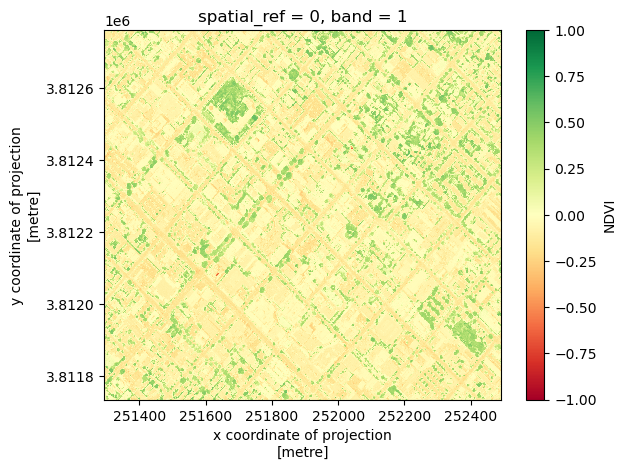

In [45]:
# Plot 
fig, ax = plt.subplots()

ndvi.plot(ax = ax,
          cmap = 'RdYlGn',
          vmin = -1,
          vmax = 1,
          cbar_kwargs = {'label':'NDVI'})

plt.show()

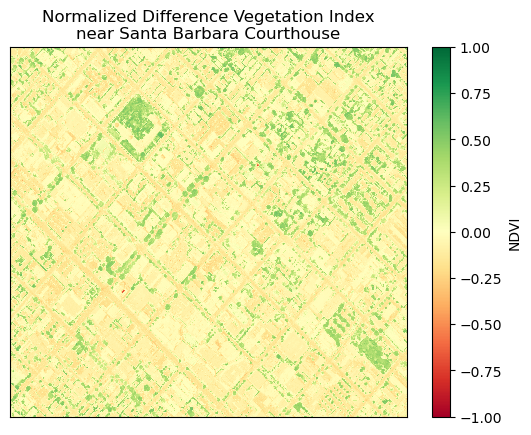

In [46]:
# Plot
fig, ax = plt.subplots()  # Adjust figure size
ndvi.plot(
    ax=ax,
    cmap="RdYlGn",  # Colormap for NDVI
    vmin=-1,  # Minimum value
    vmax=1,   # Maximum value
    cbar_kwargs={"label": "NDVI"}  # Label for color bar
)
ax.set_title("Normalized Difference Vegetation Index\nnear Santa Barbara Courthouse")  # Add title

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("")  

plt.show()